## Preparation

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import re

In [ ]:
!pip install plotly-express ipywidgets jupyter-dash

### Monthly New Repository Trends

In [45]:
df_main = pd.read_csv(
    "main.csv",
    parse_dates=[ "pushed_at", "created_at", "updated_at" ]
)
df_top = df_main[["full_name", "forks_count", "stargazers_count", "watchers_count", "open_issues_count", "created_at"]].sort_values("stargazers_count", ascending=False)
df_top['since'] = df_top['created_at'].dt.year
df_top['month'] = df_top['created_at'].dt.month
df_top = df_top.drop(columns=["created_at"])
df_monthly = df_top.groupby(["since", "month"]).agg(new_repos=pd.NamedAgg(column="full_name", aggfunc="count"))
df_monthly.reset_index(level=1, inplace=True)
df_monthly.reset_index(level=0, inplace=True)

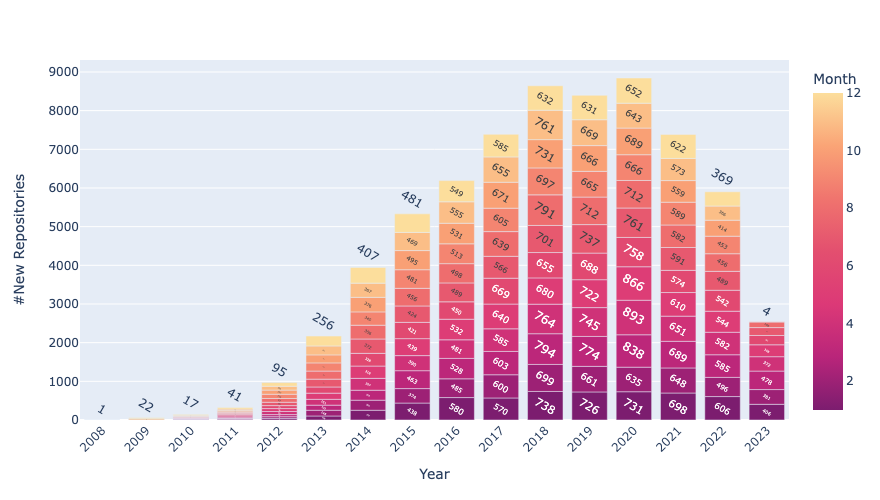

In [46]:
fig = px.bar(df_monthly, x="since", y="new_repos",
             color_continuous_scale=px.colors.sequential.Sunsetdark_r,
             color='month', barmode='stack', text="new_repos",
             labels={
                 "since": "Year",
                 "new_repos": "#New Repositories",
                 "month": "Month",
             },
             height=500)
fig.update_traces(textfont_size=12, textangle=30, cliponaxis=False)
fig.update_layout(xaxis={"dtick":1, "tickangle":-45})


fig.show()

## Topic analysis

In [ ]:
def split_by_topics(row):
    topics = row['topics']
    row['topic'] = [m.group(1) for m in re.finditer(r"'([-\w]+)'", topics)]
    if len(row['topic']) == 0: row['topic'] = 'NOTOPIC'
    return row

def expand(file):
    df = pd.read_csv(file, parse_dates=['created_at', 'updated_at', 'pushed_at'])
    df = df.apply(lambda row: split_by_topics(row), axis=1)
    df = df.explode(['topic'])
    return df

df = expand("main.csv")
sum = df.groupby("topic").agg(
    repositories=pd.NamedAgg(column="id", aggfunc="count"),
    stars=pd.NamedAgg(column="stargazers_count", aggfunc="sum"),
    folks=pd.NamedAgg(column="forks_count", aggfunc="sum"),
    watchers=pd.NamedAgg(column="watchers_count", aggfunc="sum"),
).sort_values("repositories", ascending=False)

df['year'] = df['created_at'].dt.year
sum2 = df.groupby(["year", "topic"]).agg(
    topic_members=pd.NamedAgg(column="id", aggfunc="count"),
    topic_stars=pd.NamedAgg(column="stargazers_count", aggfunc="sum"),
    topic_forks=pd.NamedAgg(column="forks_count", aggfunc="sum"),
)


df_vis = sum2.query("topic_members > 15")
df_vis.reset_index(level=1, inplace=True)
df_vis.reset_index(level=0, inplace=True)


### go-awesome category analysis

In [47]:
df_awesome = pd.read_csv("main.csv", parse_dates=['created_at', 'updated_at', 'pushed_at'])
df_awesome_cat = pd.read_csv("go-awesome-categories.csv")
df_awesome = df_awesome.merge(df_awesome_cat, how="left", on="full_name")

df_awesome['category'] = df_awesome['category'].fillna('!!NOCAT!!')

df_awesome['year'] = df_awesome['created_at'].dt.year
# sum2 = df_awesome.groupby(["year", "category"]).agg(
#     cat_members=pd.NamedAgg(column="id", aggfunc="count"),
#     cat_stars=pd.NamedAgg(column="stargazers_count", aggfunc="sum"),
#     cat_forks=pd.NamedAgg(column="forks_count", aggfunc="sum"),
# )


df_vis = df_awesome
df_vis.rename(columns={"forks_count": "cat_forks", "stargazers_count":"cat_stars" }, inplace=True)
# df_vis.reset_index(level=1, inplace=True)
# df_vis.reset_index(level=0, inplace=True)# 

In [ ]:
df_vis

### Prepare dataframe for treemap and sunburst

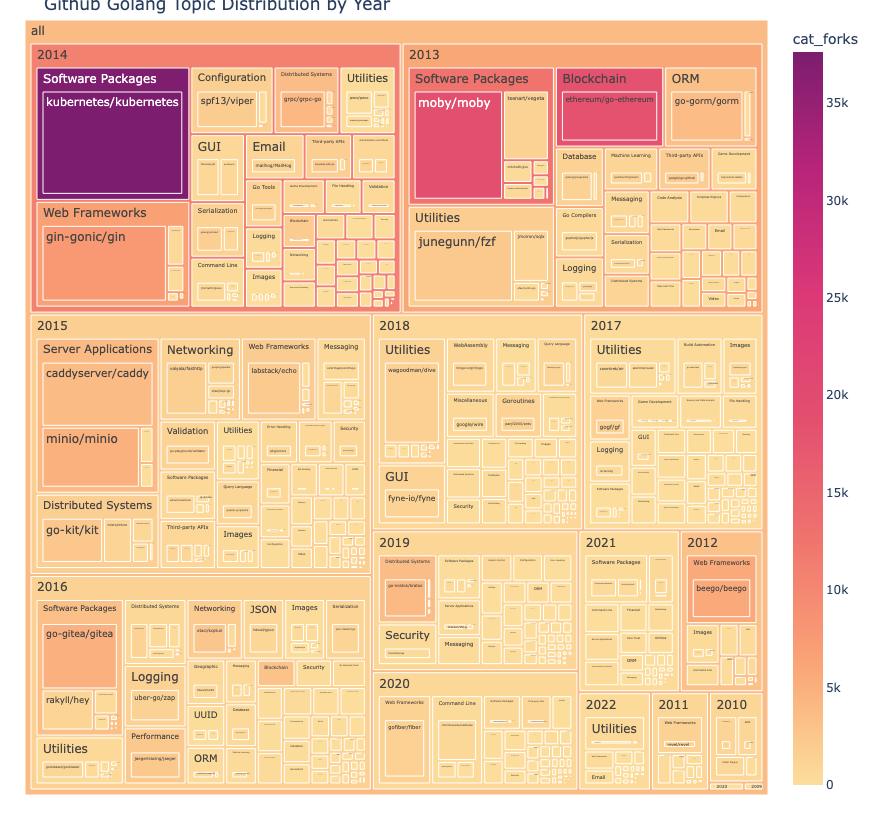

In [48]:
df_vis = df_vis.query("category != '!!NOCAT!!'")
fig = px.treemap(
    df_vis, path=[px.Constant("all"), 'year', 'category', 'full_name'],
    values='cat_stars',
    #color_continuous_scale=px.colors.sequential.Sunset,
    color_continuous_scale=px.colors.sequential.Sunsetdark,
    color='cat_forks',
    width=1200, height=820,
    title="Github Golang Topic Distribution by Year")
fig.update_layout(margin = dict(t=20, l=25, r=25, b=25))
fig.show()

In [ ]:
fig = px.sunburst(
    df_vis, path=[px.Constant("all"), 'year', 'category', 'full_name'],
    values='cat_stars',
    #color_continuous_scale=px.colors.sequential.Sunset,
    color_continuous_scale=px.colors.sequential.Sunsetdark,
    color='cat_forks',
    width=1200, height=820,
    title="Github Golang Category Distribution by Year")
fig.update_layout(margin = dict(t=20, l=25, r=25, b=25))
fig.show()